## Comparison of average rainfall in January between UBC and SFU

### Introduction

Intense rainfall is becoming more and more frequent as a result of climate change (Murdock et al., 2007), which is affecting many rainy districts such as MetroVancouver. UBC and SFU are both located in MetroVancouver, where winter is typically rainy. As January is ususally in the middle of winter, it can be considered as a typical winter month. According to Zhang et al., coastal and inland cities have different rainfall intensities (2022). Another research claims that total precipitation drops exponentially with distance from the sea for areas not covered by forests (Makarieva et al., 2009). Although these two universities are geographically close, SFU is further from the sea than UBC. Thus, our research question arises: Is there a significant difference between the average January rainfall of UBC and SFU?

Specifically, our random variable of interest is $\mu_1 - \mu_2$, where $\mu_1$ is the average January rainfall at UBC, and $\mu_2$ is the counterpart at SFU. The location parameter we choose is the mean, and we pick standard deviation as our scale parameter. The mean is chosen because it gives us a rough idea about which campus gets more rain. For example, if the mean is greater than 0, then it is likely that UBC has more rainfall than SFU. The standard deviation is chosen since it quantifies the spread of $\mu_1 - \mu_2$. If the standard deviation is large, then our variable varies much.

The two datasets we are going to use are loaded below. Each dataset contains monthly climate data collected at either UBC (Government of Canada, 1995) or SFU (Government of Canada, 2007). Note that we only have access to limited historical data, which can be considered as a sample from the population. Since the climate didn't change dramatically in a short period of time, this historical data is still representative and can be used for inferential purposes.

### Methods and Results

### Part I: Preliminary Results

In [75]:
library(tidyverse)
library(repr)
library(datateachr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)

#### 1. Read the data

In [76]:
#first we read the original datasets
UBC <- read_csv("https://raw.githubusercontent.com/jessie-liang/STAT-201/main/en_climate_monthly_BC_1108487_1957-1995_P1M.csv") 
SFU <- read_csv("https://raw.githubusercontent.com/jessie-liang/STAT-201/main/en_climate_monthly_BC_1101158_1965-2007_P1M.csv") 
head(UBC)
head(SFU)

Rows: 462 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Station Name, Date/Time, Month, Mean Max Temp Flag, Mean Min Temp ...
dbl (13): Longitude (x), Latitude (y), Climate ID, Year, Mean Max Temp (°C),...
lgl  (4): Dir of Max Gust (10's deg), Dir of Max Gust Flag, Spd of Max Gust ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 506 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Station Name, Date/Time, Month, Mean Max Temp Flag, Mean Min Temp ...
dbl (13): Longitude (x), Latitude (y), Climate ID, Year, Mean Max Temp (°C),...
lgl  (4): Dir of Max Gust (10's deg), Dir of Max Gust Flag, Spd of Max Gust ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALS

Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Mean Max Temp (°C),Mean Max Temp Flag,Mean Min Temp (°C),⋯,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow Grnd Last Day (cm),Snow Grnd Last Day Flag,Dir of Max Gust (10's deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
-123.25,49.25,VANCOUVER UBC,1108487,1957-01,1957,01,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-02,1957,02,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-03,1957,03,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-04,1957,04,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-05,1957,05,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-123.25,49.25,VANCOUVER UBC,1108487,1957-06,1957,06,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA


Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Mean Max Temp (°C),Mean Max Temp Flag,Mean Min Temp (°C),⋯,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow Grnd Last Day (cm),Snow Grnd Last Day Flag,Dir of Max Gust (10's deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-01,1965,01,NA,M,NA,⋯,NA,M,NA,M,NA,M,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-02,1965,02,5.0,NA,0.8,⋯,14.5,NA,363.2,NA,0,NA,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-03,1965,03,9.4,NA,2.5,⋯,7.1,NA,65.8,NA,0,NA,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-04,1965,04,11.4,NA,5.1,⋯,0.0,T,89.9,NA,0,NA,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-05,1965,05,13.5,NA,6.4,⋯,0.0,T,94.2,NA,0,NA,NA,NA,NA,NA
-122.92,49.28,BURNABY SIMON FRASER U,1101158,1965-06,1965,06,18.8,NA,10.4,⋯,0.0,NA,13.5,NA,0,NA,NA,NA,NA,NA


#### 2. Wrangle data into tidy format

In [77]:
#then, we wrangle the data to get a tidy dataset

UBC_SFU_January <- rbind(UBC, SFU) %>%
                    filter(Month == "01") %>%
                    select('Station Name', Year, Month, 'Total Rain (mm)' ) %>%
                    rename(Station = 'Station Name', Rainfall = 'Total Rain (mm)') %>%
                    filter(!is.na(Rainfall)) 

head(UBC_SFU_January)
tail(UBC_SFU_January)
nrow(UBC_SFU_January)

Station,Year,Month,Rainfall
<chr>,<dbl>,<chr>,<dbl>
VANCOUVER UBC,1958,01,298.5
VANCOUVER UBC,1959,01,158.2
VANCOUVER UBC,1960,01,161.5
VANCOUVER UBC,1961,01,236.0
VANCOUVER UBC,1962,01,140.5
VANCOUVER UBC,1963,01,18.3


Station,Year,Month,Rainfall
<chr>,<dbl>,<chr>,<dbl>
BURNABY SIMON FRASER U,2002,01,151.4
BURNABY SIMON FRASER U,2003,01,239.4
BURNABY SIMON FRASER U,2004,01,235.2
BURNABY SIMON FRASER U,2005,01,360.4
BURNABY SIMON FRASER U,2006,01,458.4
BURNABY SIMON FRASER U,2007,01,367.6


[1] 75

#### 3. Sample Statistic Summary

In [78]:
#calculate sample statistic

n_UBC <- UBC_SFU_January %>%
        filter(Station == "VANCOUVER UBC") %>%
        summarize(n_1 = n()) %>%
        pull()

n_SFU <- UBC_SFU_January %>%
        filter(Station == "BURNABY SIMON FRASER U") %>%
        summarize(n_2 = n()) %>%
        pull()

mu1 <- UBC_SFU_January %>%
        filter(Station == "VANCOUVER UBC") %>%
        summarize(mean1 = mean(Rainfall)) %>%
        pull()

mu2 <- UBC_SFU_January %>%
        filter(Station == "BURNABY SIMON FRASER U") %>%
        summarize(mean2 = mean(Rainfall)) %>%
        pull()

var_UBC <- UBC_SFU_January %>%
        filter(Station == "VANCOUVER UBC") %>%
        summarize(var_1 = var(Rainfall)) %>%
        pull()

var_SFU <- UBC_SFU_January %>%
        filter(Station == "BURNABY SIMON FRASER U") %>%
        summarize(var_2 = var(Rainfall)) %>%
        pull()

sample_statistic <- mu1 - mu2

sd_of_sampling_dist <- sqrt(var_UBC/n_UBC + var_SFU/n_SFU)
            
summary <- tibble(n_UBC = n_UBC,
                 n_SFU = n_SFU,
                 mean_UBC = mu1,
                 mean_SFU = mu2,
                 var_UBC = var_UBC,
                 var_SFU = var_SFU,
                 sample_statistic = sample_statistic,
                 sd_of_sampling_dist = sd_of_sampling_dist)

summary

n_UBC,n_SFU,mean_UBC,mean_SFU,var_UBC,var_SFU,sample_statistic,sd_of_sampling_dist
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
38,37,155.0658,232.5622,5021.174,13603.2,-77.49637,22.35599


#### 4. Plot raw data

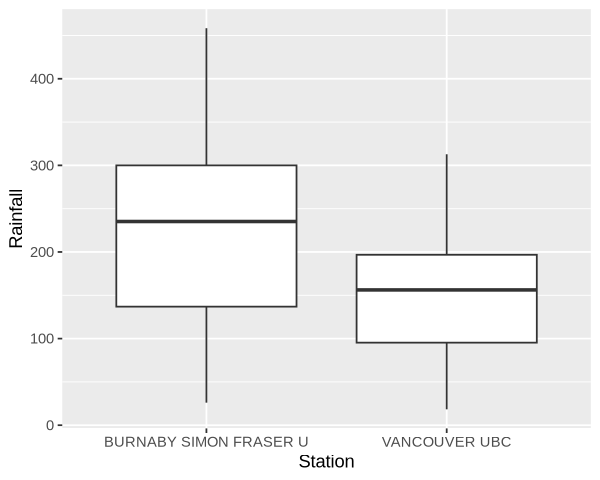

In [79]:
#boxplot
boxplot <- UBC_SFU_January %>%
            ggplot(aes(Station, Rainfall)) +
            geom_boxplot()
options(repr.plot.width = 5, repr.plot.height =4) 

boxplot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


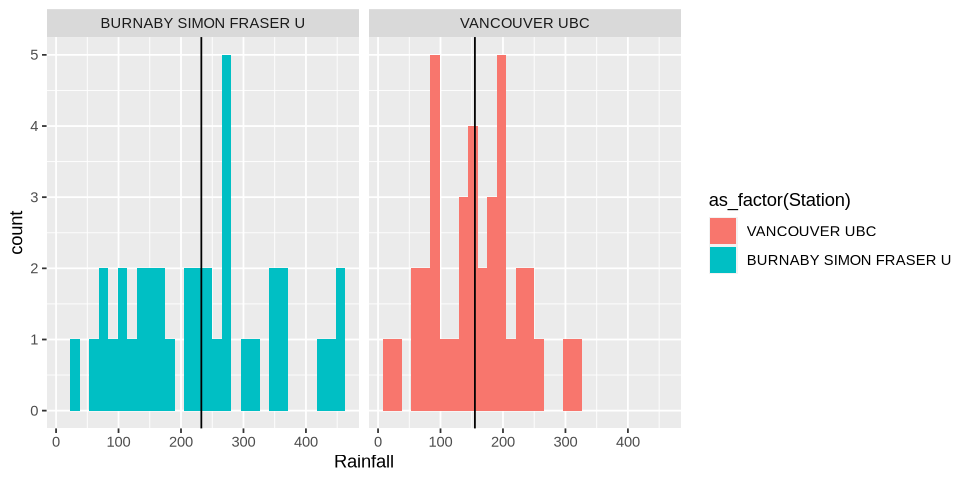

In [80]:
#side-by-side histogram

sample_dist <- UBC_SFU_January %>%
  group_by(Station) %>%
  mutate(mean = mean(Rainfall)) %>%
  ungroup %>%
  ggplot(aes(x = Rainfall, fill = as_factor(Station)))+
  geom_histogram()+
  geom_vline(aes(xintercept = mean), color="black")+
  facet_wrap(~Station)

options(repr.plot.width = 8, repr.plot.height =4) 
sample_dist

### Part II: Inferential Analysis and Results

### 1. Confidence Intervals

#### Method 1: by bootstrapping with percentile method

In [81]:
bootstrap_dist <- UBC_SFU_January %>%
        specify(formula = Rainfall ~ Station) %>%
        generate(reps = 5000, type = "bootstrap") %>%
        calculate(stat = "diff in means", order=c("VANCOUVER UBC", "BURNABY SIMON FRASER U")) 
head(bootstrap_dist)

replicate,stat
<int>,<dbl>
1,-77.12889
2,-64.20967
3,-69.20541
4,-29.98421
5,-58.21257
6,-97.45641


In [82]:
percentile_ci <- bootstrap_dist %>% 
  get_confidence_interval(level = 0.95, type = "percentile")
percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
-122.2907,-34.9393


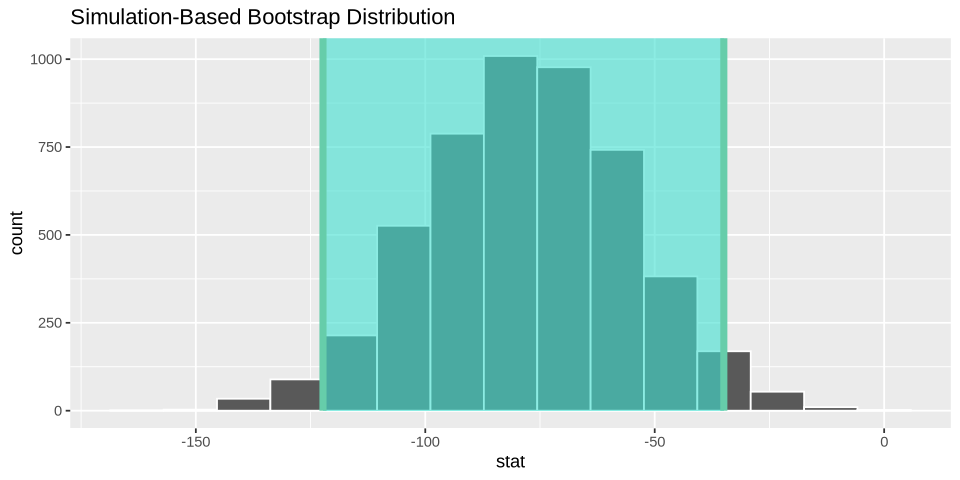

In [83]:
visualize(bootstrap_dist) + 
  shade_confidence_interval(endpoints = percentile_ci)

#### Method 2: by bootstrapping with standard error method

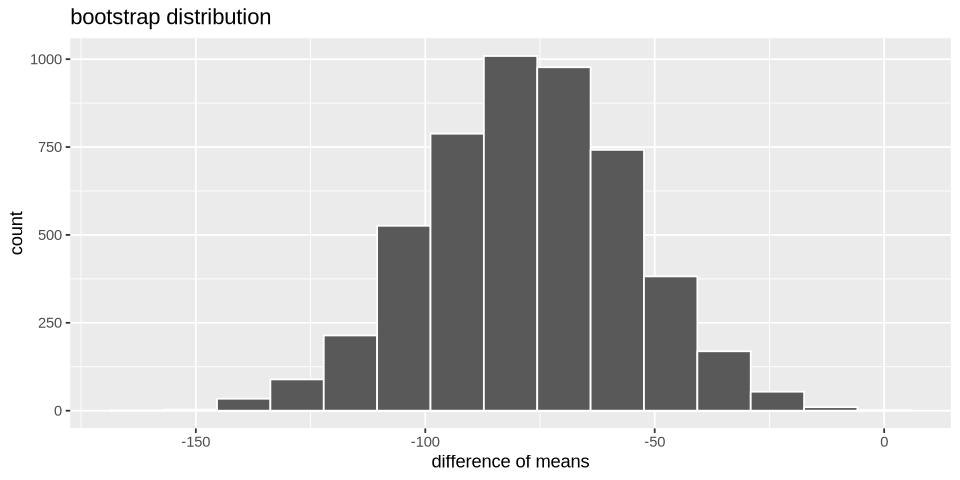

In [84]:
#first we check whether the bootstrap distribution is normally shaped

bootstrap_dist %>% visualize() +
        labs(x = "difference of means", title = "bootstrap distribution")

In [85]:
standard_error_ci <- bootstrap_dist %>% 
  get_confidence_interval(type = "se", level = 0.95, point_estimate = sample_statistic)
standard_error_ci

lower_ci,upper_ci
<dbl>,<dbl>
-120.9222,-34.07053


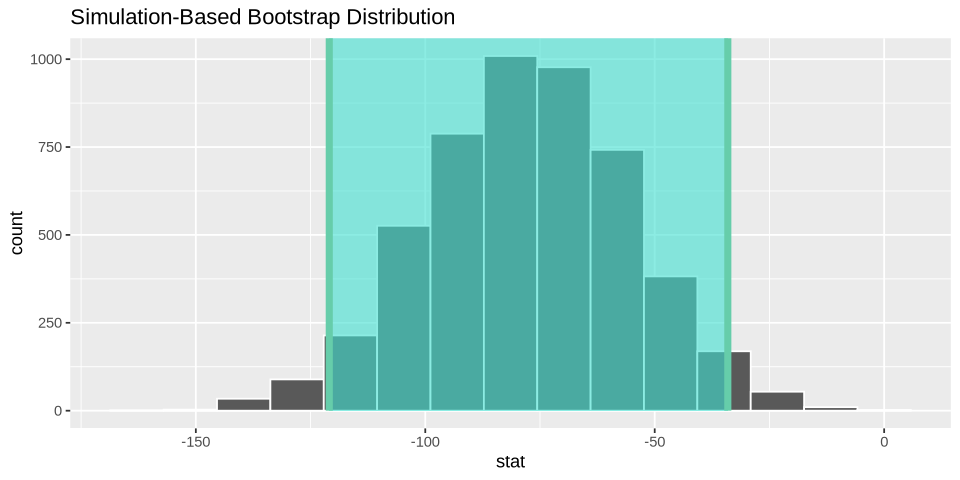

In [86]:
visualize(bootstrap_dist) + 
  shade_confidence_interval(endpoints = standard_error_ci)

#### Method 3: Asymptotics methods by CLT

We use the following formula:

$$CI(\mu_1 - \mu_2) = (\overline{X_1} - \overline{X_2}) \pm t^\ast \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$

Here, the t-distribution has degree of freedom $min(n_1-1, n_2-2)$ approximately. (Yu, n.d.)

In [87]:
df <- min(n_UBC-1, n_SFU-1)
CLT_ci <- 
     tibble(
         lower_ci = mu1 - mu2 - qt(0.975, df) * sqrt(var_UBC/n_UBC + var_SFU/n_SFU),
         upper_ci = mu1 - mu2 + qt(0.975, df) * sqrt(var_UBC/n_UBC + var_SFU/n_SFU)
     )
CLT_ci

lower_ci,upper_ci
<dbl>,<dbl>
-122.8364,-32.15633


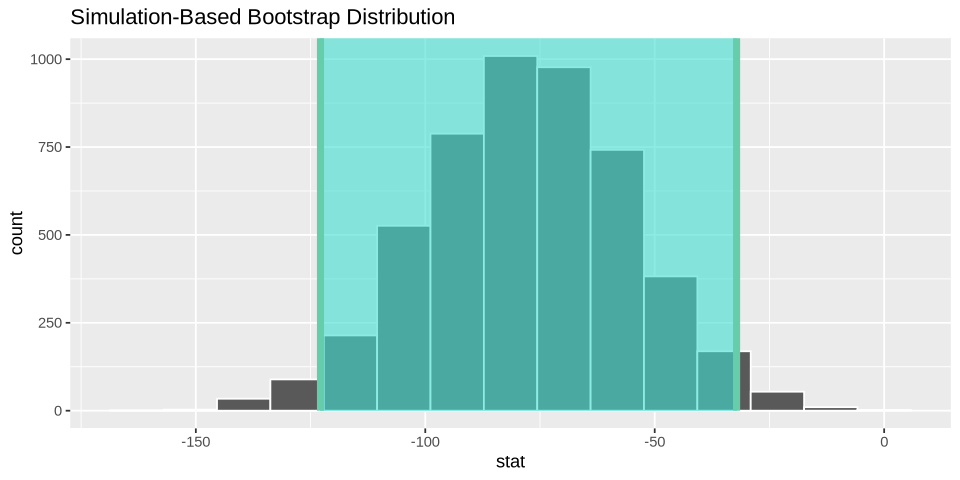

In [88]:
visualize(bootstrap_dist) + 
  shade_confidence_interval(endpoints = CLT_ci)

### 2. Hypothesis Testing

#### Method 1: by computer simulation

To perform computer-simulated hypothesis testing, we use a modified version of infer workflow. This includes, five major parts-specify, hypothesize, generate, calculate and visualize.

In [89]:
rainfall_generate <- UBC_SFU_January %>% 
  specify(formula = Rainfall ~ Station) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute")

nrow(rainfall_generate)

[1] 75000

For this dataset, the workflow is as follows-
1. **specify**
We use formula = response ~ explanatory where Rainfall is the response variable for our dataset and Station is the explanatory variable.
2. **hypothesize**
As our dataset involved two samples(UBC & SFU), we set null = "independence".
3. **generate**
This is done to generate replicates of “shuffled” datasets assuming the null hypothesis is true. Here, we set type = "permute", because permutations are a kind of resampling that involve resampling without replacement.
4. **calculate**
Now we calculate the test-statistic for the 1000 shuffles generated in the previous step by setting stat = "diff in means".
5. **visualize**
We visualize the null_distribution next, also we use the shade_p_value() function with obs_stat and set the direction = "right" reflecting our alternative hypothesis.

In [90]:
null_distribution <- UBC_SFU_January %>% 
  specify(formula = Rainfall ~ Station) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "diff in means", order = c("VANCOUVER UBC", "BURNABY SIMON FRASER U"))
null_distribution

replicate,stat
<int>,<dbl>
1,18.467354
2,29.055903
3,17.427169
4,20.430370
5,32.107112
6,-8.140043
7,20.403698
8,-9.542959
9,-39.302916


In [91]:
obs_diff_means <- UBC_SFU_January %>% 
  specify(formula = Rainfall ~ Station) %>% 
  calculate(stat = "diff in means", order = c("VANCOUVER UBC", "BURNABY SIMON FRASER U"))
obs_diff_means

stat
<dbl>
-77.49637


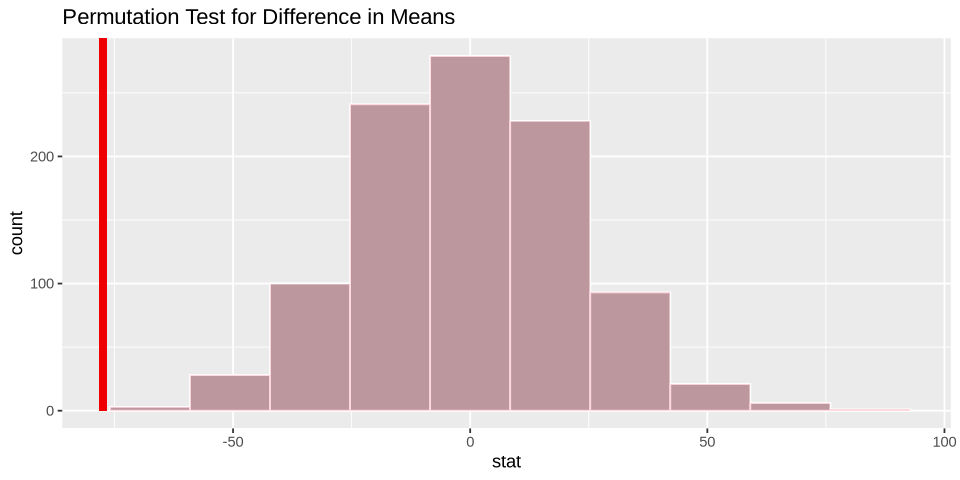

In [92]:
visualize(null_distribution, bins = 10) + 
  shade_p_value(obs_stat = obs_diff_means, direction = "right")+
  labs(title = "Permutation Test for Difference in Means")

In [93]:
null_distribution %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "right")

p_value
<dbl>
1


#### Method 2: by theoretical formula

When researchers didn’t have access to computers that could run thousands of calculations quickly and efficiently, the traditional theory-based methods were used. Since, with changing times and easy and cheap access to computer power, the need to use traditional theory-based methods has declined but still researchers in many fields continue to use theory-based methods. Thus, we chose to include this here.

The theory-based method is ultimately an approximation to the simulation-based method.Here, we are focusing on two-sample t-test for testing differences in sample means.

We use the following formula to calculate t-statistic:

$$t = \frac {(\overline{x_1} - \overline{x_2})- (\overline{\mu_1} - \overline{\mu_2})} {\sqrt{\frac{s_a^2}{n_a} + \frac{s_r^2}{n_r}}}$$

As we know, large sample sizes correspond to large degrees of freedom and thus produce t-distributions that closely align with the standard normal z-curve. So, our formula for the test statistic simplifies a bit the observed two-sample t-test statistic is:



$$t = \frac {(\overline{x_1} - \overline{x_2})} {\sqrt{\frac{s_a^2}{n_a} + \frac{s_r^2}{n_r}}}$$

In [34]:
obs_two_sample_t <- UBC_SFU_January %>% 
  specify(formula = Rainfall ~ Station) %>% 
  calculate(stat = "t", order = c("VANCOUVER UBC", "BURNABY SIMON FRASER U"))
obs_two_sample_t

stat
<dbl>
-3.466471


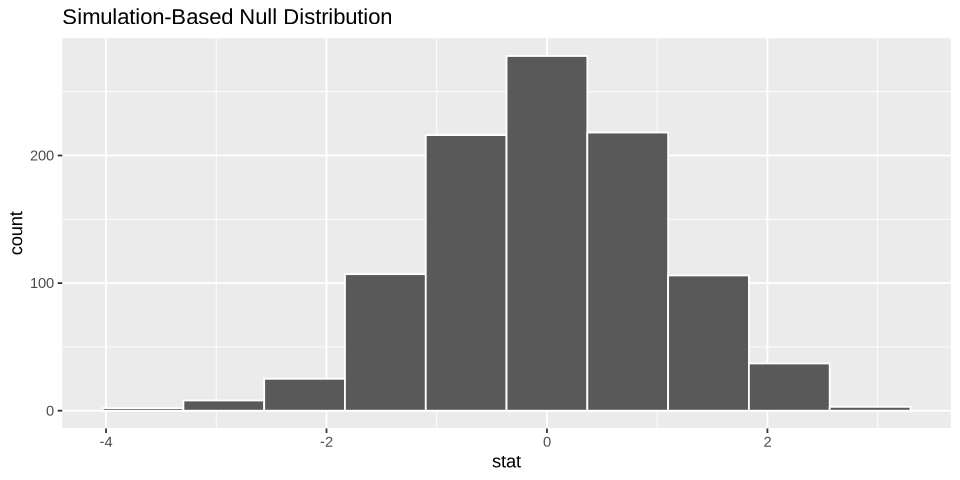

In [35]:
# Construct null distribution of t:
null_distribution_rainfall_t <- UBC_SFU_January %>% 
  specify(formula = Rainfall ~ Station) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "t", order = c("VANCOUVER UBC", "BURNABY SIMON FRASER U"))

visualize(null_distribution_rainfall_t, bins = 10) 

Warning message:
“Check to make sure the conditions have been met for the theoretical method. {infer} currently does not check these for you.”


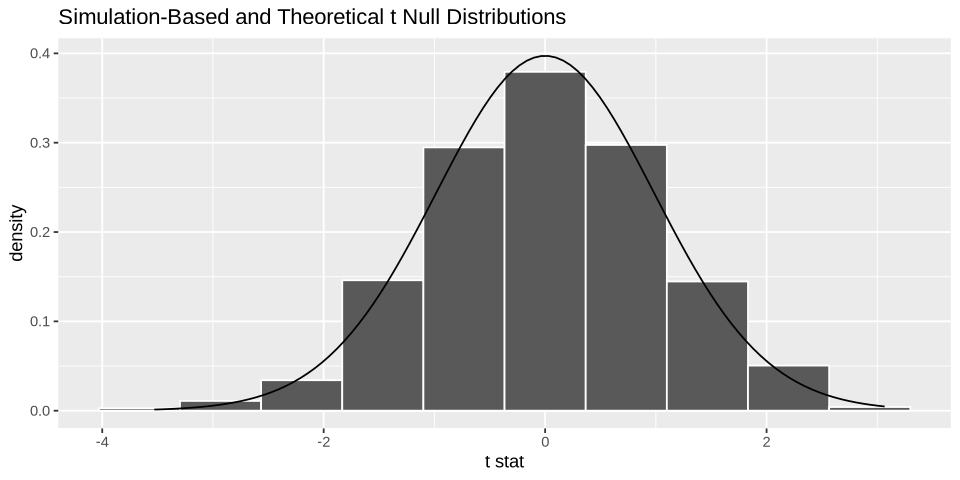

In [36]:
visualize(null_distribution_rainfall_t, bins = 10, method = "both")

Warning message:
“Check to make sure the conditions have been met for the theoretical method. {infer} currently does not check these for you.”


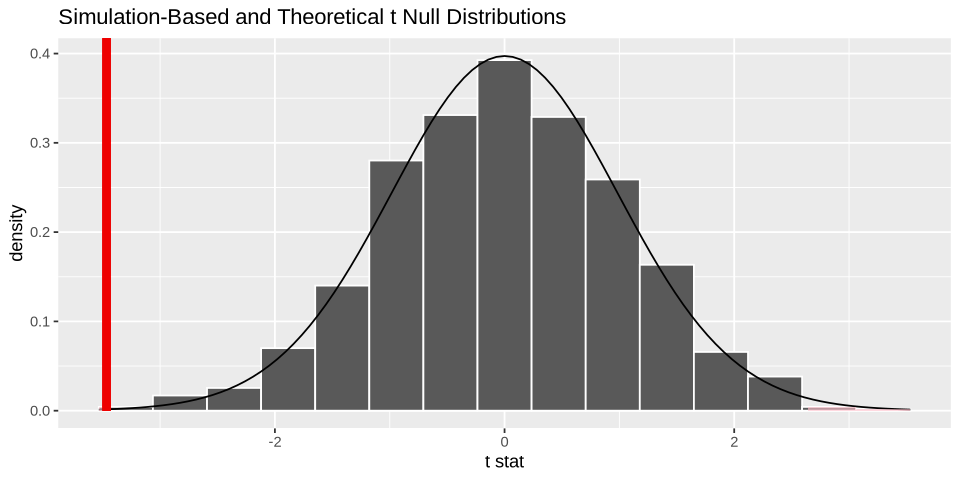

In [37]:
visualize(null_distribution_rainfall_t, method = "both") +
  shade_p_value(obs_stat = obs_two_sample_t, direction = "both")

In [38]:
null_distribution_rainfall_t %>% 
  get_p_value(obs_stat = obs_two_sample_t, direction = "both")

p_value
<dbl>
0.004


In order for the results of our two-sample t-test to be valid, three conditions must be met:

* Nearly normal populations or large sample sizes. A general rule of thumb that works in many (but not all) situations is that the sample size n should be greater than 30. (As n_UBC = 38 and n_SFU = 37, this condition is fulfilled.)
* Both samples are selected independently of each other. (As we're extracting data for UBC and SFU independently,the observations in one sample are not influenced by or dependent on the observations in the other sample.)
* All observations are independent from each other. (It seems that each row of our dataset represents a monthly observation, and there is no indication of dependency between observations. Thus, the condition is fulfilled.)

### Discussion

#### 1. Summary of our result

#### 2. Implications/impacts of our findings

As for the impacts, our report can help both universities consider how to keep campuses safe during the rainy season. Also, our report can provide information from a climate perspective for high school students who are choosing which university to apply.

#### 3. Result vs Our expectation

#### 4. Further questions

Our report may lead to future questions such as: Why is the rainfall different between UBC and SFU? How will the rainfall change in the future in these two universities? What is the pattern of rainfall in other seasons between UBC and SFU?

### References

Government of Canada. (2007). en_climate_monthly_BC_1101158_1965-2007_P1M [Dataset]. https://climate.weather.gc.ca/climate_data/monthly_data_e.html?hlyRange=%7C&dlyRange=1965-02-01%7C2022-06-04&mlyRange=1965-01-01%7C2007-02-01&StationID=731&Prov=BC&urlExtension=_e.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2023&selRowPerPage=25&Line=0&searchMethod=contains&Month=10&Day=27&txtStationName=Simon+Fraser&timeframe=3&Year=2007

Government of Canada. (1995). en_climate_monthly_BC_1108487_1957-1995_P1M [Dataset]. https://climate.weather.gc.ca/climate_data/monthly_data_e.html?hlyRange=%7C&dlyRange=1957-09-01%7C1995-06-30&mlyRange=1957-01-01%7C1995-06-01&StationID=903&Prov=BC&urlExtension=_e.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2023&selRowPerPage=25&Line=6&searchMethod=contains&Month=6&Day=27&txtStationName=UBC&timeframe=3&Year=1995

Makarieva, A. M., Gorshkov, V. G., & Li, B.-L. (2009). Precipitation on land versus distance from the ocean: Evidence for a forest pump of atmospheric moisture. Ecological Complexity, 6(3), 302–307. https://doi.org/10.1016/j.ecocom.2008.11.004
‌

Trevor Q. Murdock, Katrina E. Bennett, & Arelia T. Werner. (2007). GVRD Historical and Future Rainfall Analysis Update.

Yu, Eugenia (n.d.). Comparing Means between Two Independent Groups [PowerPoint slides]. Department of Statistics, University of British Columbia. https://canvas.ubc.ca/courses/126179/files/27859553?module_item_id=5901773

Zhang, W., Yang, J., Yang, L., & Niyogi, D. (2022). Impacts of City Shape on Rainfall in Inland and Coastal Environments. Earth’s Future, 10(5). https://doi.org/10.1029/2022ef002654